# Twitter Sentiment Analysis 
## Capstone 2 Project by Hanna Freudenreich

Microblogging websites such as Twitter have started to become a source of varied information about users' opinions on a variety of topics and/or products. Polling on microblogs can give a sense of general sentiment towards a topic or product and can be used by companies to study user reactions. Here, a technology is necessary to detect and summarize an overall sentiment.
Here, I build models for binary classification of sentiment of tweets into positive and negative classes.
I use a dataset of 10,000 human annotated tweets on the novel Coronavirus collected in 2020 (https://www.kaggle.com/imranzaman5202/covid19-sentiment-analysis).
The dataset was obtained via Twitter search (not streaming??) API collecting tweets against the keyword “coronavirus”. More details can be found in the link.
Sentiment analysis is performed usind the nltk package in Python and following the steps outlined here: https://www.digitalocean.com/community/tutorials/how-to-perform-sentiment-analysis-in-python-3-using-the-natural-language-toolkit-nltk



###  1. Data Preparation and Cleaning

In [1]:
#import packages 
import nltk
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re, string
from nltk.tokenize import word_tokenize
from nltk.tag import pos_tag
from nltk.corpus import stopwords
from nltk import FreqDist
from nltk.tokenize import TweetTokenizer
from nltk.stem.wordnet import WordNetLemmatizer
from wordcloud import WordCloud
from emot.emo_unicode import UNICODE_EMO, EMOTICONS

In [2]:
#import tweet data
data = pd.read_csv("tweets_tagged.csv",delimiter=',', encoding='latin-1')
print(data.head())
print(data.describe())

   Sr No                                              tweet  label
0      1  Hysteria surrounding #coronavirus NZ daycare r...      3
1      2  Thank you @TheOnion for dragging all of us und...      1
2      3  #avetmissdone is catching on faster than the #...      1
3      4  They just said #Tonysnell was back from the fl...      2
4      5  Forget locking them up on an island to die slo...      2
             Sr No         label
count  10000.00000  10000.000000
mean    5000.50000      1.879200
std     2886.89568      0.784518
min        1.00000      1.000000
25%     2500.75000      1.000000
50%     5000.50000      2.000000
75%     7500.25000      3.000000
max    10000.00000      3.000000


In [3]:
#remove urls 
def remove_URL(sample):
    """Remove URLs from a string"""
    return re.sub(r"http\S+", "", sample)
print(data['tweet'][1])
data['tweet']=[remove_URL(tweet) for tweet in data['tweet']]
print(data['tweet'][1])

Thank you @TheOnion for dragging all of us under the artful guise of satire. V helpful #coronavirus advice ?? https://t.co/Oly95Sul5f
Thank you @TheOnion for dragging all of us under the artful guise of satire. V helpful #coronavirus advice ?? 


In [4]:
#seperate dataframe to positive, negative, and both tweets
pos_tweets =data['tweet'][data['label']==1]
neg_tweets = data['tweet'][data['label']==3]
pos_neg_tweets = data['tweet'][data['label']!=2]


In [5]:
#to lower case  
pos_neg_tweets = [tweet.lower() for tweet in pos_neg_tweets]
pos_tweets = [tweet.lower() for tweet in pos_tweets]
neg_tweets = [tweet.lower() for tweet in neg_tweets]

In [6]:
print(pos_tweets[:5])
print(neg_tweets[:5])

['thank you @theonion for dragging all of us under the artful guise of satire. v helpful #coronavirus advice ?? ', '#avetmissdone is catching on faster than the #coronavirus... but no deaths yet! ??', '#wuhancoronavirus #coronavirus\na young man was recovered and discharged from a local hospital in shanxi. best wishes! ???\n', '#wuhancoronavirus #coronavirus\na young man was recovered and discharged from the local hospital in shanxi. best wishes! ????????? ', 'japan flies citizens home from virus-hit wuhan  via @youtube #coronavirus ??']
['hysteria surrounding #coronavirus nz daycare requesting all children who have visited a country with any confirmed cases be excluded for 2 weeks. this includes australia. so, despite us only visiting adelaide where there are no confirmed cases, we are in this category ??', 'please keep posted!?????? #coronavirus #gensan #stelizabethhospitalinc #sehi ', 'what did richard jefferson say? ?? #coronavirus ', 'halt???\nall??commercial??flights??from #china

In [7]:
#convert emoticons to words before tokenizing, so they don't get deleted

# Function for converting emoticons into word

def convert_emoticons(text):
    for emot in EMOTICONS:
        emo_string= "_".join(EMOTICONS[emot].replace(",","").split())
        text = re.sub(u'('+emot+')',emo_string, text)
        text=text.replace("_".join(EMOTICONS[emot].replace(",","").split()), " "+"_".join(EMOTICONS[emot].replace(",","").split()))
    return text

#count emoticons - why doesnt this work??

count_emot=0
def count_emoticons(text):
    for emot in EMOTICONS:
        global count_emot
        #emot="\"%s\"" % emot
        count_emot+=text.count(emot)
    return count_emot
    

#example
text2 = "Hilarious:-). The feeling of making a sale :-(, The feeling of actually fulfilling orders :-)"

print(convert_emoticons(text2))
print(count_emoticons( "Hilarious:-)."))


Hilarious           Happy_face_smiley. The feeling of making a sale              Frown_sad_andry_or_pouting, The feeling of actually fulfilling orders            Happy_face_smiley
0


In [8]:
#use Tweet tokenizer (preserves hashtag and @)
tknzr = TweetTokenizer()

pos_tokens = [tknzr.tokenize(tweet) for tweet in pos_tweets]
neg_tokens = [tknzr.tokenize(tweet) for tweet in neg_tweets]
tweet_tokens = [tknzr.tokenize(tweet) for tweet in pos_neg_tweets]
print(pos_tokens[1])
print(neg_tokens[1])
print(tweet_tokens[1])

['#avetmissdone', 'is', 'catching', 'on', 'faster', 'than', 'the', '#coronavirus', '...', 'but', 'no', 'deaths', 'yet', '!', '?', '?']
['please', 'keep', 'posted', '!', '?', '?', '?', '#coronavirus', '#gensan', '#stelizabethhospitalinc', '#sehi']
['thank', 'you', '@theonion', 'for', 'dragging', 'all', 'of', 'us', 'under', 'the', 'artful', 'guise', 'of', 'satire', '.', 'v', 'helpful', '#coronavirus', 'advice', '?', '?']


In [9]:
#normalization 
#tagging position of word in sentence
#show example for first tweet
print(pos_tag(pos_tokens[0]))

[('thank', 'NN'), ('you', 'PRP'), ('@theonion', 'VBP'), ('for', 'IN'), ('dragging', 'VBG'), ('all', 'DT'), ('of', 'IN'), ('us', 'PRP'), ('under', 'IN'), ('the', 'DT'), ('artful', 'JJ'), ('guise', 'NN'), ('of', 'IN'), ('satire', 'NN'), ('.', '.'), ('v', 'NN'), ('helpful', 'JJ'), ('#coronavirus', 'NN'), ('advice', 'NN'), ('?', '.'), ('?', '.')]


In [10]:
#remove noise and lemmatize (copy and pasted from blog)

def remove_noise(tweet_tokens, stop_words = ()):

    cleaned_tokens = []

    for token, tag in pos_tag(tweet_tokens):
        token = re.sub('http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+#]|[!*\(\),]|'\
                       '(?:%[0-9a-fA-F][0-9a-fA-F]))+','', token)
    
        #token = re.sub("(@[A-Za-z0-9_]+)","", token) #this would delete @handles?
        token=re.sub("([^A-Za-z#])","", token) #this deletes all numbers and punctuations, though it also transforms #ncov19 to #ncov
        if tag.startswith("NN"):
            pos = 'n'
        elif tag.startswith('VB'):
            pos = 'v'
        else:
            pos = 'a'

        lemmatizer = WordNetLemmatizer()
        token = lemmatizer.lemmatize(token, pos)
        #use if condition to drop single character strings
        if len(token) > 1 and token not in string.punctuation and token.lower() not in stop_words:
            cleaned_tokens.append(token.lower())
    return cleaned_tokens

In [11]:
#define stopwords to remove
stop_words = stopwords.words('english')

In [12]:
#apply remove_noise function
pos_tokens_cleaned = []
neg_tokens_cleaned = []
tweet_tokens_cleaned = []

for tokens in pos_tokens:
    pos_tokens_cleaned.append(remove_noise(tokens, stop_words))

for tokens in neg_tokens:
    neg_tokens_cleaned.append(remove_noise(tokens, stop_words))

for tokens in tweet_tokens:
    tweet_tokens_cleaned.append(remove_noise(tokens, stop_words))

### 2. Exploratory Data Analysis

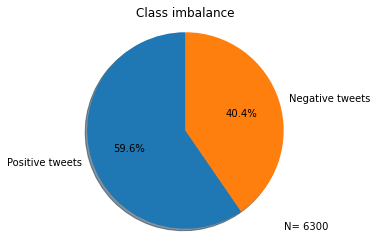

In [13]:
#examine the data
#share of positive tweets

# Pie chart, where the slices will be ordered and plotted counter-clockwise:
labels = 'Positive tweets', 'Negative tweets'
shares = [len(pos_tweets)/len(pos_neg_tweets), (1-len(pos_tweets)/len(pos_neg_tweets))]
fig1, ax1 = plt.subplots()
ax1.pie(shares, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
n=len(pos_neg_tweets)
plt.text(1, -1, "N= %d" % n)
plt.title("Class imbalance")

plt.show()

In [14]:
#count words to later drop most frequent words and plot a histogram

word_counter={}
for tweet in tweet_tokens_cleaned:
    for word in tweet:
        if word != '':
            if word in word_counter:
                word_counter[word] +=1
            else:
                word_counter[word] = 1

popular_words = sorted(word_counter, key = word_counter.get, reverse = True)
top_200 = popular_words[:200]
top_50=popular_words[:50]
top_10 = popular_words[:10]


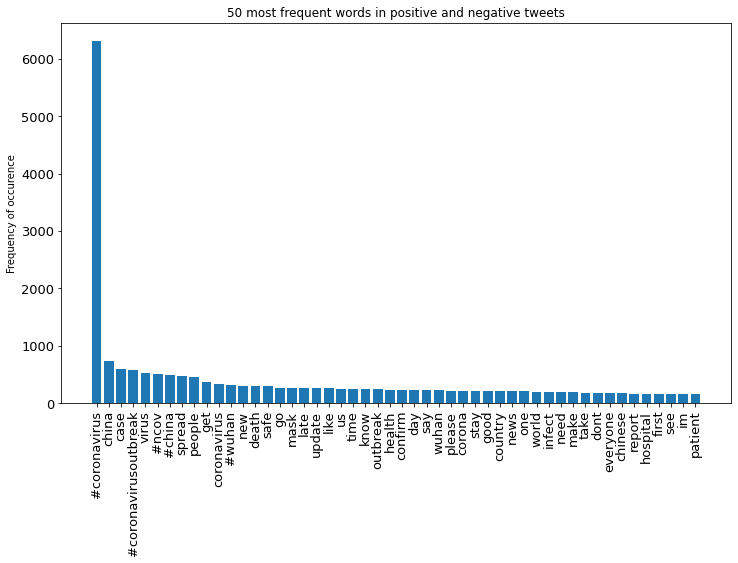

In [15]:
#plot most distribution of 50 most common words
#get values of word_counter for most common 50 words
freq = []
words = []
sorted_freq=dict(sorted(word_counter.items(), key=lambda item: item[1], reverse=True))
for key, value in sorted_freq.items():
    if key in top_50:
        freq.append(value)
        words.append(key)
#make bar plot of most frequent words
fig, ax = plt.subplots(figsize=(12, 7))
plt.bar(height=freq, x=words, width=0.8)
plt.xticks(rotation=90)
plt.tick_params(axis='both', which='major', labelsize=13)
plt.title("50 most frequent words in positive and negative tweets")
plt.ylabel("Frequency of occurence")
plt.show()


In [16]:
#make list of pos and negative words from list of tweets 
#to be able to delete most frequent words and count words looping over list
pos_words = []
neg_words = []

for tweet in pos_tokens_cleaned:
    for word in tweet:
        pos_words.append(word)
        
for tweet in neg_tokens_cleaned:
    for word in tweet:
        neg_words.append(word)

In [17]:
#count and plot top words in positive and negative tweets that are not in top_10
count_pos={}
for word in pos_words:
    if word not in top_10:
        if word in count_pos:
            count_pos[word] +=1
        else:
            count_pos[word] = 1

popular_pos_words = sorted(count_pos, key = count_pos.get, reverse = True)
top_20_pos_words=popular_pos_words[:20]
count_neg={}
for word in neg_words:
    if word not in top_10:
        if word in count_neg:
            count_neg[word] +=1
        else:
            count_neg[word] = 1

In [18]:
#get frequencies from dictionaries in a sorted way as tuples for plotting top20
#positive
freq_pos = []
words_pos = []
sorted_freq_pos= [(k, v) for k, v in count_pos.items()]
sorted_freq_pos=sorted(sorted_freq_pos, key=lambda tup: tup[1], reverse=True)
words_pos = [a for (a,_) in sorted_freq_pos]
freq_pos = [b for (_,b) in sorted_freq_pos]

In [19]:
#negative
freq_neg = []
words_neg = []
sorted_freq_neg= [(k, v) for k, v in count_neg.items()]
sorted_freq_neg=sorted(sorted_freq_neg, key=lambda tup: tup[1], reverse=True)
words_neg = [a for (a,_) in sorted_freq_neg]
freq_neg = [b for (_,b) in sorted_freq_neg]

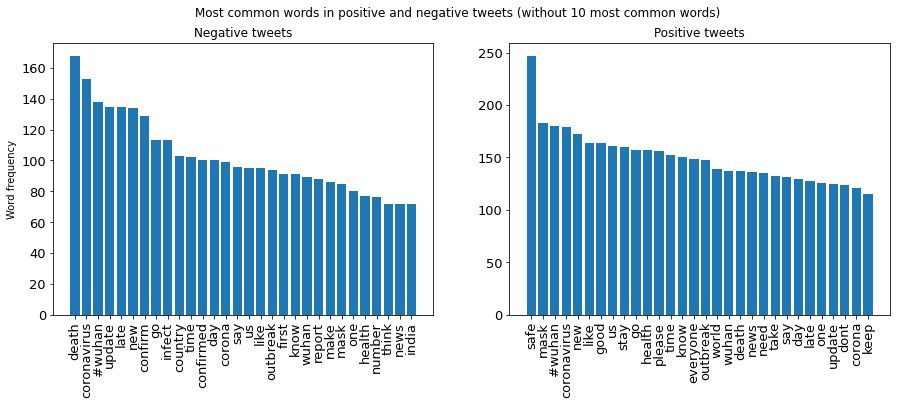

In [20]:
#make bar plot of frequencies 
fig, ax = plt.subplots(figsize=(15, 5))
plt.subplot(1,2,1)

#This will create first plot
neg = plt.bar(words_neg[:30], freq_neg[:30])
plt.title('Negative tweets')
plt.ylabel('Word frequency')
plt.xticks(rotation='vertical')
plt.tick_params(axis='both', which='major', labelsize=13)
#The below code will create the second plot.
plt.subplot(1,2,2)
#This will create the second plot
pos =plt.bar(words_pos[:30], freq_pos[:30])
plt.title('Positive tweets')
plt.xticks( rotation='vertical')
plt.tick_params(axis='both', which='major', labelsize=13)
plt.suptitle('Most common words in positive and negative tweets (without 10 most common words)')
plt.show() 

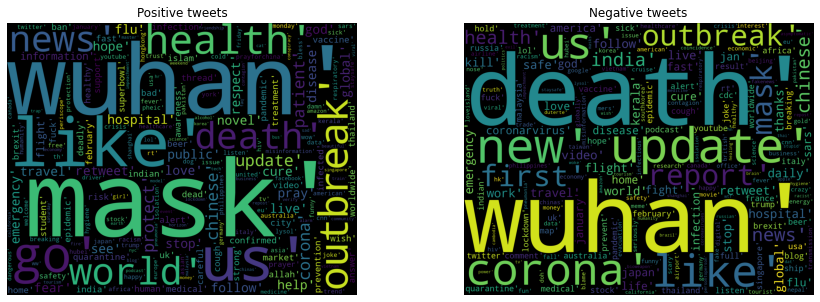

In [21]:
#in addition make word cloud as alternative illustration

from wordcloud import WordCloud
fig, ax = plt.subplots(figsize=(15, 5))

#positive
plt.subplot(1,2,1)
wordcloud_pos = WordCloud(width=1800,height=1400).generate(str(words_pos))
plt.imshow(wordcloud_pos)
plt.title('Positive tweets')
plt.axis("off")

#negative
plt.subplot(1,2,2)
wordcloud_neg = WordCloud(width=1800,height=1400).generate(str(words_neg))
plt.imshow(wordcloud_neg)
plt.title('Negative tweets')
plt.axis("off")

plt.show()

### 3. Modelling

In [22]:
#preparing data for modelling

#make dict out of lists of tokens with keys = tokens and values=true
#IS THIS WHAT IS REFERRED TO AS ONE HOT ENCODING?
def get_tweets_for_model(cleaned_tokens_list):
    for tweet_tokens in cleaned_tokens_list:
        yield dict([token, True] for token in tweet_tokens)

positive_tokens_for_model = get_tweets_for_model(pos_tokens_cleaned)
negative_tokens_for_model = get_tweets_for_model(neg_tokens_cleaned)

In [23]:
#test and training set split for Naive Bayes model

#joining positive and negative tweets with additional tag, and shuffle into 1 set
import random

positive_dataset = [(tweet_dict, "Positive")
                     for tweet_dict in positive_tokens_for_model]

negative_dataset = [(tweet_dict, "Negative")
                     for tweet_dict in negative_tokens_for_model]

dataset = positive_dataset + negative_dataset
random.shuffle(dataset)

#we have 6,300 tweets after dropping the neutral ones
# set training dataset size to 0.7 of all data
train_size=int(len(dataset)*0.7) 
train_data = dataset[:train_size]
test_data = dataset[train_size:]

In [24]:
#Using NLTK Package to build Naive Bayes Model 
#it has slightly different accuracy from sklearn Naive Bayes module below 
from nltk import classify
from nltk import NaiveBayesClassifier
classifier = NaiveBayesClassifier.train(train_data)

print("Accuracy of Naive Bayes Model is:", classify.accuracy(classifier, test_data))
print(classifier.show_most_informative_features(10))

Accuracy of Naive Bayes Model is: 0.5904761904761905
Most Informative Features
                 respect = True           Positi : Negati =     11.3 : 1.0
              contagious = True           Negati : Positi =      8.1 : 1.0
                 visitor = True           Negati : Positi =      8.1 : 1.0
                  weaken = True           Negati : Positi =      8.1 : 1.0
                    heal = True           Positi : Negati =      8.1 : 1.0
                database = True           Negati : Positi =      6.8 : 1.0
                #peruzzi = True           Negati : Positi =      6.2 : 1.0
                   drive = True           Negati : Positi =      6.2 : 1.0
                  handle = True           Negati : Positi =      6.2 : 1.0
                politics = True           Negati : Positi =      6.2 : 1.0
None


In [25]:
#Transform dataset to use with other models from sklearn package
#requires count vectorization 

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics

# Create our vectorizer
vectorizer = CountVectorizer()

In [26]:
#to use count vectorization, format of x (tweets) needs to be a simple list of strings

neg_list = []
pos_list = []

for tweet in neg_tokens_cleaned:
    tw=''
    for word in tweet:
        tw=tw+word+' '
    tw=tw[:-1] #get rid of space at the end of tweet
    neg_list.append(tw)

for tweet in pos_tokens_cleaned:
    tw=''
    for word in tweet:
        tw=tw+word+' '
    tw=tw[:-1] #get rid of space at the end of tweet
    pos_list.append(tw)
    
#add positive and negative category and shuffle

pos_set = [(tweet, 1)
                     for tweet in pos_list]

neg_set = [(tweet, 0)
                     for tweet in neg_list]

ds = pos_set + neg_set
random.shuffle(ds)

# set training dataset size to 0.7 of all data
train_size=int(len(ds)*0.7) 
train_data = ds[:train_size]
test_data = ds[train_size:]

#generate x_train, y_train, x_test, y_test
x_test = [a for (a,_) in test_data]
x_train = [a for (a,_) in train_data]
y_test = [b for (_,b) in test_data]
y_train = [b for (_,b) in  train_data]

# Get the training vectors
vectors = vectorizer.fit_transform(x_train)

# Get the test vectors
vectors_test = vectorizer.transform(x_test)

##### Naive Bayes Classifier

The multinomial naive Bayes classifier is a simple classification algorithm that naively assumes independence of features. It treats the text document as a "bag-of-words", that is, an unordered set of words with their position ignored, keeping only their frequency in the document, and assumes that the probabilities of all words are independent of eachother. Naive Bayes is a probabilistic classifier, meaning that for a document d, out of all classes c ∈ C the classifier returns the class which has the maximum posterior probability given the document p(features|class) (source: https://web.stanford.edu/~jurafsky/slp3/4.pdf). 


In [27]:
#Naive Bayes
# Build the classifier
nb= MultinomialNB(alpha=.01)

#  Train the classifier
nb.fit(vectors, y_train)

# Predict and score the vectors
nb_pred = nb.predict(vectors_test)
nb_acc_score = metrics.accuracy_score(y_test, nb_pred)
nb_f1_score = metrics.f1_score(y_test, nb_pred, average='macro')

print('Naive Bayes: Total accuracy classification score: {}'.format(nb_acc_score))
print('Naive Bayes: Total F1 classification score: {}'.format(nb_f1_score))


Naive Bayes: Total accuracy classification score: 0.5984126984126984
Naive Bayes: Total F1 classification score: 0.5727739952962284


#### Logistic Regression 
While Naive Bayes is a generative classifier, whicht computes p(features|class) first, logistic regression is a popular discriminative classifier, meaning it allows to directly compute p(class|features) (https://towardsdatascience.com/sentiment-classification-with-logistic-regression-analyzing-yelp-reviews-3981678c3b44#c3b8).
Logistic regression is a supervised classification algorithm. The model builds a regression model to predict the probability that a given data entry belongs to the class numbered as “1”. Just like Linear regression assumes that the data follows a linear function, Logistic regression models the data using the sigmoid function. Logistic regression becomes a classification technique only when a decision threshold is chosen. (https://www.geeksforgeeks.org/understanding-logistic-regression/#:~:text=Logistic%20regression%20is%20basically%20a,regression%20IS%20a%20regression%20model.)
A parameter to be adjusted is the regularization parameter C. It applies a pply a penalty to increase the magnitude of parameter values in order to avoid overfitting. 

In [28]:
#Logistic regression

# Build the classifier with different values of regularization strengths

def logreg(cval):
    lr= LogisticRegression(C=cval)
    lr.fit(vectors, y_train) #train
    lr_pred = lr.predict(vectors_test) #predict
    lr_acc_score = metrics.accuracy_score(y_test, lr_pred)
    lr_f1_score = metrics.f1_score(y_test, lr_pred, average='macro')
    return lr_acc_score, lr_f1_score, lr

    # Predict and score the vectors for different values of C
c=[0.001, 0.01, 0.1, 1,10,100]
class_weight=[None, 'balanced']

for  cval in c:
    print('Logistic Regression for C=%f:  Total accuracy classification score: %f, Total F1 classification score: %f' %  (cval,  logreg(cval)[0], logreg(cval)[1]))

Logistic Regression for C=0.001000:  Total accuracy classification score: 0.605291, Total F1 classification score: 0.377060
Logistic Regression for C=0.010000:  Total accuracy classification score: 0.623810, Total F1 classification score: 0.450702
Logistic Regression for C=0.100000:  Total accuracy classification score: 0.624868, Total F1 classification score: 0.554087
Logistic Regression for C=1.000000:  Total accuracy classification score: 0.596296, Total F1 classification score: 0.563645


C:\Users\freudenreich\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\freudenreich\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regres

Logistic Regression for C=10.000000:  Total accuracy classification score: 0.589947, Total F1 classification score: 0.564484
Logistic Regression for C=100.000000:  Total accuracy classification score: 0.578307, Total F1 classification score: 0.555400


C:\Users\freudenreich\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [29]:
#Decision tree classifier

# Build the classifier with different parameter specifications
    #default
dt1= DecisionTreeClassifier()
    #specify parameters: criterion=entropy
dt2= DecisionTreeClassifier(criterion='entropy')
    #class weight= balanced
dt3= DecisionTreeClassifier(class_weight='balanced')
    #random splitter
dt4= DecisionTreeClassifier(splitter="random")


#  Train the classifier
dt1.fit(vectors, y_train)
dt2.fit(vectors,y_train)
dt3.fit(vectors,y_train)
dt4.fit(vectors,y_train)

# Predict and score the vectors
dt1_pred = dt1.predict(vectors_test)
dt1_acc_score = metrics.accuracy_score(y_test, dt1_pred)
dt1_f1_score = metrics.f1_score(y_test, dt1_pred, average='macro')
dt2_pred = dt2.predict(vectors_test)
dt2_acc_score = metrics.accuracy_score(y_test, dt2_pred)
dt2_f1_score = metrics.f1_score(y_test, dt2_pred, average='macro')
dt3_pred = dt3.predict(vectors_test)
dt3_acc_score = metrics.accuracy_score(y_test, dt3_pred)
dt3_f1_score = metrics.f1_score(y_test, dt3_pred, average='macro')
dt4_pred = dt4.predict(vectors_test)
dt4_acc_score = metrics.accuracy_score(y_test, dt4_pred)
dt4_f1_score = metrics.f1_score(y_test, dt4_pred, average='macro')

print('Decision Tree Classifier: Total accuracy classification score: {}'.format(dt1_acc_score))
print('Decision Tree Classifier: Total F1 classification score: {}'.format(dt1_f1_score))
print('Decision Tree Classifier with criterion=entropy: Total accuracy classification score: {}'.format(dt2_acc_score))
print('Decision Tree Classifier with criterion = entropy: Total F1 classification score: {}'.format(dt2_f1_score))
print('Decision Tree Classifier with class_weight=balanced: Total accuracy classification score: {}'.format(dt3_acc_score))
print('Decision Tree Classifier with class_weight=balanced: Total F1 classification score: {}'.format(dt3_f1_score))
print('Decision Tree Classifier with random splitter: Total accuracy classification score: {}'.format(dt4_acc_score))
print('Decision Tree Classifier with random splitter: Total F1 classification score: {}'.format(dt4_f1_score))

Decision Tree Classifier: Total accuracy classification score: 0.5576719576719577
Decision Tree Classifier: Total F1 classification score: 0.5439362958635493
Decision Tree Classifier with criterion=entropy: Total accuracy classification score: 0.5566137566137566
Decision Tree Classifier with criterion = entropy: Total F1 classification score: 0.5454649813286558
Decision Tree Classifier with class_weight=balanced: Total accuracy classification score: 0.5735449735449736
Decision Tree Classifier with class_weight=balanced: Total F1 classification score: 0.5607966287780936
Decision Tree Classifier with random splitter: Total accuracy classification score: 0.5603174603174603
Decision Tree Classifier with random splitter: Total F1 classification score: 0.5475904414405877


In [30]:
#Random forest classifier

# Build the classifier
rf= RandomForestClassifier()

#  Train the classifier
rf.fit(vectors, y_train)

# Predict and score the vectors
rf_pred = rf.predict(vectors_test)
rf_acc_score = metrics.accuracy_score(y_test, rf_pred)
rf_f1_score = metrics.f1_score(y_test, rf_pred, average='macro')

print('Random Forest Classifier: Total accuracy classification score: {}'.format(rf_acc_score))
print('Random Forest Classifier: Total F1 classification score: {}'.format(rf_f1_score))

Random Forest Classifier: Total accuracy classification score: 0.5936507936507937
Random Forest Classifier: Total F1 classification score: 0.5617391304347826


In [31]:
#ROC curve

#import packages
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

# generate a no skill prediction (majority class)
ns_probs = [0 for _ in range(len(y_test))]

# predict probabilities for each of the classifiers
# and keep probabilities for the positive outcome only

nb_probs = nb.predict_proba(vectors_test)[:, 1] #naive bayes
lr_probs = logreg(1)[2].predict_proba(vectors_test)[:, 1] #logistic regression with default c
lr01_probs = logreg(0.1)[2].predict_proba(vectors_test)[:, 1] #logistic regression with c=.1
lr10_probs = logreg(10)[2].predict_proba(vectors_test)[:, 1] #logistic regression with c=.1
dt1_probs = dt1.predict_proba(vectors_test)[:, 1] #decision tree classifier, base specification
dt2_probs = dt2.predict_proba(vectors_test)[:, 1]  #decision tree classifier with criterion=entropy
dt3_probs = dt3.predict_proba(vectors_test)[:, 1]  #decision tree classifier with classweight=balanced
dt4_probs = dt4.predict_proba(vectors_test)[:, 1] #decision tree classifier with random splitter
rf_probs = rf.predict_proba(vectors_test)[:, 1] #random forest classifier

C:\Users\freudenreich\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


No Skill: ROC AUC=0.500
Naive Bayes: ROC AUC=0.599
Logistic: ROC AUC=0.610
Logistic: ROC AUC=0.625
Logistic: ROC AUC=0.594
Decision Tree: ROC AUC=0.539
Decision Tree: ROC AUC=0.544
Decision Tree: ROC AUC=0.562
Decision Tree: ROC AUC=0.548
Random forest: ROC AUC=0.608


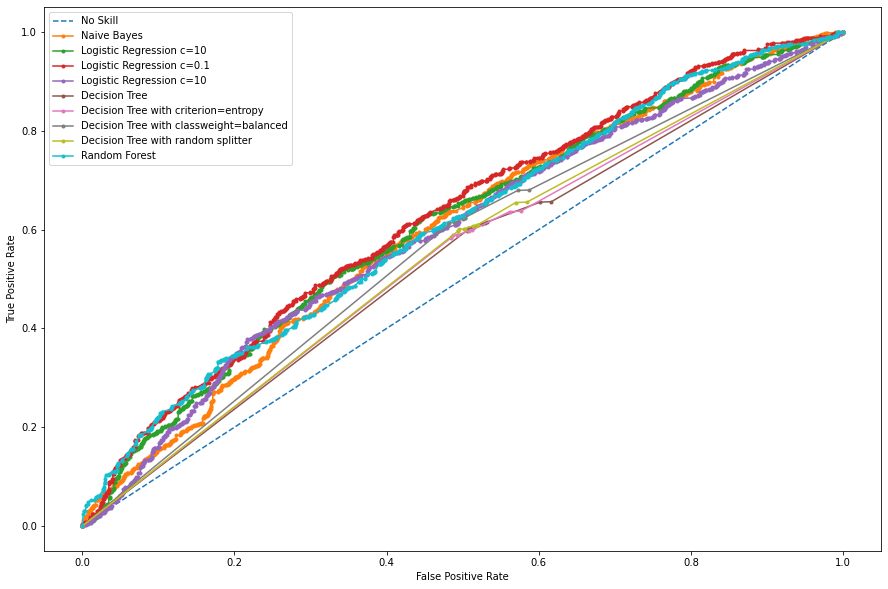

In [32]:
# calculate roc auc scores
ns_auc = roc_auc_score(y_test, ns_probs) #no skill
nb_auc = roc_auc_score(y_test, nb_probs) #naive bayes
lr_auc = roc_auc_score(y_test, lr_probs) #logistic regression 1
lr01_auc = roc_auc_score(y_test, lr01_probs) #logistic regression 2
lr10_auc = roc_auc_score(y_test, lr10_probs) #logistic regression 3
dt1_auc = roc_auc_score(y_test, dt1_probs) #decision tree 1
dt2_auc = roc_auc_score(y_test, dt2_probs) #decision tree 2
dt3_auc = roc_auc_score(y_test, dt3_probs) #decision tree 3
dt4_auc = roc_auc_score(y_test, dt4_probs) #decision tree 4
rf_auc = roc_auc_score(y_test, rf_probs) #random forests


# summarize scores
print('No Skill: ROC AUC=%.3f' % (ns_auc))
print('Naive Bayes: ROC AUC=%.3f' % (nb_auc))
print('Logistic: ROC AUC=%.3f' % (lr_auc))
print('Logistic: ROC AUC=%.3f' % (lr01_auc))
print('Logistic: ROC AUC=%.3f' % (lr10_auc))
print('Decision Tree: ROC AUC=%.3f' % (dt1_auc))
print('Decision Tree: ROC AUC=%.3f' % (dt2_auc))
print('Decision Tree: ROC AUC=%.3f' % (dt3_auc))
print('Decision Tree: ROC AUC=%.3f' % (dt4_auc))
print('Random forest: ROC AUC=%.3f' % (rf_auc))

# calculate roc curves
ns_fpr, ns_tpr, _ = roc_curve(y_test, ns_probs)
nb_fpr, nb_tpr, _ = roc_curve(y_test, nb_probs)
lr_fpr, lr_tpr, _ = roc_curve(y_test, lr_probs)
lr01_fpr, lr01_tpr, _ = roc_curve(y_test, lr01_probs)
lr10_fpr, lr10_tpr, _ = roc_curve(y_test, lr10_probs)
dt1_fpr, dt1_tpr, _ = roc_curve(y_test, dt1_probs)
dt2_fpr, dt2_tpr, _ = roc_curve(y_test, dt2_probs)
dt3_fpr, dt3_tpr, _ = roc_curve(y_test, dt3_probs)
dt4_fpr, dt4_tpr, _ = roc_curve(y_test, dt4_probs)
rf_fpr, rf_tpr, _ = roc_curve(y_test, rf_probs)

# plot the roc curve for the model
fig, ax = plt.subplots(figsize=(15, 10))
plt.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
plt.plot(nb_fpr, nb_tpr, marker='.', label='Naive Bayes')
plt.plot(lr_fpr, lr_tpr, marker='.', label='Logistic Regression c=10')
plt.plot(lr01_fpr, lr01_tpr, marker='.', label='Logistic Regression c=0.1')
plt.plot(lr10_fpr, lr10_tpr, marker='.', label='Logistic Regression c=10')
plt.plot(dt1_fpr, dt1_tpr, marker='.', label='Decision Tree ')
plt.plot(dt2_fpr, dt2_tpr, marker='.', label='Decision Tree with criterion=entropy')
plt.plot(dt3_fpr, dt3_tpr, marker='.', label='Decision Tree with classweight=balanced')
plt.plot(dt4_fpr, dt4_tpr, marker='.', label='Decision Tree with random splitter')
plt.plot(rf_fpr, rf_tpr, marker='.', label='Random Forest')

# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# show the legend
plt.legend()
# show the plot
plt.show()